# SmartSifter

In [1]:
#-*- coding:utf-8 -*-
import os
home = os.getcwd()
os.chdir("../src/")
from sdle import SDLE
from sdem import SDEM
os.chdir(home)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rd
import itertools
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as st

%matplotlib inline

In [2]:
def d_h_Gauss(mu, sigma, mu_prev, sigma_prev):
    '''
    t時点とt-1時点におけるガウス分布間のヘリンジャー距離
    '''
    #第2項
    m = 2 * np.linalg.det((np.linalg.inv(sigma) + np.linalg.inv(sigma_prev)) / 2) ** (-1/2) #分子
    d = (np.linalg.det(sigma) ** (1/4)) * (np.linalg.det(sigma_prev) ** (1/4)) #分母
    A = m / d
    
    #第3項 1番目exp
    B_0 = (np.dot(np.linalg.inv(sigma), mu) + np.dot(np.linalg.inv(sigma_prev), mu_prev)).T #要素1
    B_1 = np.linalg.inv(np.linalg.inv(sigma) + np.linalg.inv(sigma_prev)) #要素2
    B_2 = np.dot(np.linalg.inv(sigma), mu) + np.dot(np.linalg.inv(sigma_prev), mu_prev) #要素3
    B = np.exp((1/2) * np.dot(np.dot(B_0, B_1), B_2))
    
    #第3項 2番目exp
    C_0 = np.dot(np.dot(mu.T, np.linalg.inv(sigma)), mu) + np.dot(np.dot(mu_prev.T, np.linalg.inv(sigma_prev)), mu_prev) #要素
    C = np.exp(-(1/2) * C_0)
    
    #ヘリンジャー距離の計算
    d_h = 2 - A * B * C
    
    return d_h


def d_h_GMM(pi, pi_prev, mu, sigma, mu_prev, sigma_prev, k):
    '''
    t時点とt-1時点における混合ガウス分布のヘリンジャー距離
    '''
    d_h = 0
    for i in range(k):
        d_h_G = d_h_Gauss(mu[i], sigma[i], mu_prev[i], sigma_prev[i])
        d_h += (np.sqrt(pi[i]) - np.sqrt(pi_prev[i])) ** 2 + (pi[i] + pi_prev[i])/2 * d_h_G
    
    return d_h


def calc_hellinger_score(p, p_prev, sdem, t, r, k, M):
    '''
    ヘリンジャースコアを計算する関数
    '''
    S_H = 0
    for m in range(M):
        d_h = d_h_GMM(sdem[m].pi[t], sdem[m].pi[t-1] ,sdem[m].mu[t], sdem[m].sigma[t], 
                      sdem[m].mu[t-1], sdem[m].sigma[t-1], k)
        tmp = np.sqrt(p[m] * p_prev[m]) #√(p_t(x)*p_t_1(x))      
        S_H += tmp * (d_h - 2)
    S_H += 2
    S_H /= r**2
    
    return S_H

In [3]:
seed = 0
#データ生成(離散値ベクトル)
rd.seed(seed)
T = 500 #データ数(観測数)
x = np.array([np.argmax(i) for i in rd.multinomial(1, [1/6]*6,T)])
x = np.array([np.argmax(i) for i in rd.multinomial(1, [1]*1,T)])
#x = np.zeros(T)

#データ生成(連続変数ベクトル)
n = [200, 150, 150] #各データ数
K = 3 #潜在変数の数
D = 2 #次元

#mu:D次元
mu_true = np.array(
    [[0.2, 0.5],
     [1.2, 0.5],
     [2.0, 0.5]])

#sigma: D×D次元
sigma_true = np.array(
    [[[0.1,  0.085], [0.085, 0.1]],
     [[0.1, -0.085], [-0.085, 0.1]],
     [[0.1,  0.085], [0.085, 0.1]]
    ])

rd.seed(seed)
org_data = None
for i in range(K):
    #k_0 に属するデータを生成
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
        
    #k_1, k_2に属するデータを生成し、結合する
    else:
        tmp_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
        org_data = np.r_[org_data, tmp_data]

#print(org_data)
y = org_data[:, :2]

In [4]:
#パラメータの設定
#SDLE
A = list(itertools.product(set(x)))
r = 1 / len(x) #忘却パラメータ
beta = 1 #正の定数

#SDEM
alpha = 1.0 #(1.0~2.0)
r = 1 / T
k = K #潜在変数の数
d = D #次元

In [5]:
# オブジェクトの初期化
sdle = SDLE(r, beta, A)
sdem = [SDEM(r, alpha, k, d) for i in range(len(A))]

In [6]:
#結果保存用
p = np.zeros((1,len(A))) #同時確率
S_H = [] #ヘリンジャースコア
S_L = [] #シャノン情報量(対数損失)

In [7]:
t = 1
while t <= len(x):
    #SDLE
    sdle.update(x[t-1])
    
    #p に一行追加
    p_new = np.zeros((1,len(A)))
    p = np.concatenate([p, p_new])
    
    #SDEM: 各セルに対応する混合ガウス分布のパラメータと確率を推定
    for m, A_m in enumerate(sdle.A):
        if m == int(sdle.flag):
            sdem[m].update(y[t-1])
            p_y_x = np.dot(sdem[m].prob[t], sdem[m].pi[t])
            p[t, m] = p_y_x * sdle.prob[t, int(sdle.flag)] #t時点における同時確率:p_t(x,y)
        else:
            sdem[m].skip()
            p[t, m] = p[t-1, m]
            
    #スコア計算(シャノン情報量)
    p_x_prev = sdle.prob[t-1, sdle.flag]
    pi_prev = sdem[int(sdle.flag)].pi[t-1]
    mu_prev = sdem[int(sdle.flag)].mu[t-1]
    sigma_prev = sdem[int(sdle.flag)].sigma[t-1]
    p_Gauss_prev = sdem[int(sdle.flag)].calc_prob(y[t-1], mu_prev, sigma_prev)
    p_y_x_prev = np.dot(pi_prev, p_Gauss_prev)
    p_prev_params = p_x_prev * p_y_x_prev #t-1時点のパラメータによる同時確率:P(x,y)
    s_l = -np.log(p_prev_params) #シャノン情報量を計算
    S_L.append(s_l)
    
    #ヘリンジャースコア
    s_h = calc_hellinger_score(sdle.prob[t], sdle.prob[t-1], sdem, t, r, k, sdle.M)
    S_H.append(s_h)
    
    t += 1

/Users/satetsu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log


In [8]:
df = pd.DataFrame(x)
df_S_L = pd.DataFrame(S_L)
df_S_H = pd.DataFrame(S_H)
df_S_L.columns = ["S_L"]
df_S_H.columns = ["S_H"]
df = pd.concat([df, df_S_L, df_S_H], axis=1)

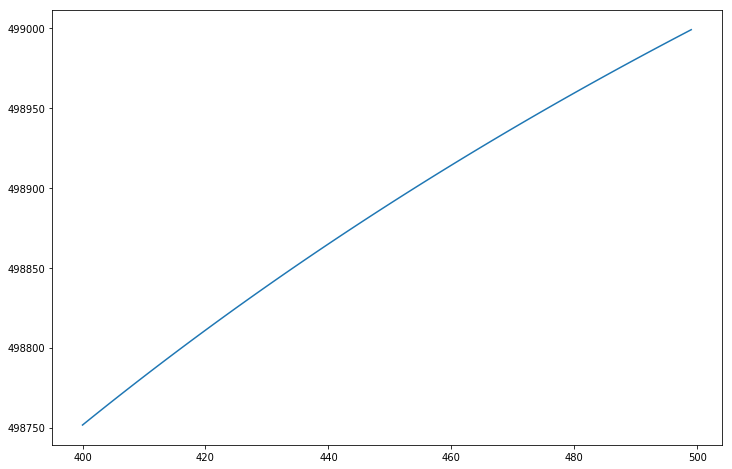

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(df[400:].S_H)

In [38]:
sdle.A_det

array([ 500.])